In [5]:
#!pip install imblearn
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from joblib import dump, load
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras import layers
import keras
import matplotlib.pyplot as plt
import seaborn as sns

2023-11-17 17:05:25.495692: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 17:05:26.038934: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 17:05:26.038978: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 17:05:26.042100: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 17:05:26.385858: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 17:05:26.388419: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [30]:
data = pd.read_excel("./code_plagiarism.xls")
data

,File Name 1,File Name 2,Per_Functions,Per_Loops,Per_Conditionals,Per_Arithmetic_Operations,Per_int_Declarations,Per_float_Declarations,Per_char_Declarations,Jaccard_Metric,Euclidean_Distance,label
0,000.c,001.c,0.518519,0.166667,0.250000,0.000000,0.166667,0,0.018182,0.818182,0.000289,0
1,000.c,002.c,0.928571,0.333333,0.500000,0.000000,0.250000,0,0.250000,0.818182,0.008141,0
2,000.c,003.c,0.875000,1.000000,1.000000,0.000000,0.500000,0,0.000000,0.777778,0.186989,0
3,000.c,004.c,0.785714,0.000000,0.500000,0.000000,0.000000,0,0.000000,0.555556,0.107115,0
4,000.c,005.c,0.714286,0.333333,0.500000,0.000000,0.200000,0,0.142857,0.666667,0.012363,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2998,074.c,076.c,0.262500,0.333333,0.225806,0.107143,0.333333,0,0.224138,1.000000,0.014874,0
2999,074.c,077.c,0.412500,0.222222,0.548387,0.285714,0.227273,0,0.149425,1.000000,0.016872,0
3000,075.c,076.c,0.552632,0.166667,0.500000,0.000000,0.909091,0,0.155172,0.916667,0.007293,0
3001,075.c,077.c,0.868421,0.111111,0.823529,0.000000,0.083333,0,0.103448,0.916667,0.009313,0


In [31]:
non_zero_cells_per_column = data.astype(bool).sum(axis=0)
percentages_non_zero_cells_per_column = (non_zero_cells_per_column * 100) / (data.shape[0])
percentages_non_zero_cells_per_column

File Name 1                  100.000000
File Name 2                  100.000000
Per_Functions                100.000000
Per_Loops                     73.626374
Per_Conditionals              87.512488
Per_Arithmetic_Operations     40.792541
Per_int_Declarations          67.132867
Per_float_Declarations         0.000000
Per_char_Declarations         53.146853
Jaccard_Metric               100.000000
Euclidean_Distance           100.000000
label                          0.865801
dtype: float64

In [32]:
# Obtaining the columns that have more than 90% of null values
columns_to_drop = percentages_non_zero_cells_per_column < 10
columns_to_drop = columns_to_drop[columns_to_drop]
columns_to_drop = columns_to_drop.index
columns_to_drop = columns_to_drop.drop("label")
columns_to_drop

Index(['Per_float_Declarations'], dtype='object')

In [33]:
clean_data = data.drop(columns_to_drop, axis = 1)
clean_data

,File Name 1,File Name 2,Per_Functions,Per_Loops,Per_Conditionals,Per_Arithmetic_Operations,Per_int_Declarations,Per_char_Declarations,Jaccard_Metric,Euclidean_Distance,label
0,000.c,001.c,0.518519,0.166667,0.250000,0.000000,0.166667,0.018182,0.818182,0.000289,0
1,000.c,002.c,0.928571,0.333333,0.500000,0.000000,0.250000,0.250000,0.818182,0.008141,0
2,000.c,003.c,0.875000,1.000000,1.000000,0.000000,0.500000,0.000000,0.777778,0.186989,0
3,000.c,004.c,0.785714,0.000000,0.500000,0.000000,0.000000,0.000000,0.555556,0.107115,0
4,000.c,005.c,0.714286,0.333333,0.500000,0.000000,0.200000,0.142857,0.666667,0.012363,0
...,...,...,...,...,...,...,...,...,...,...,...
2998,074.c,076.c,0.262500,0.333333,0.225806,0.107143,0.333333,0.224138,1.000000,0.014874,0
2999,074.c,077.c,0.412500,0.222222,0.548387,0.285714,0.227273,0.149425,1.000000,0.016872,0
3000,075.c,076.c,0.552632,0.166667,0.500000,0.000000,0.909091,0.155172,0.916667,0.007293,0
3001,075.c,077.c,0.868421,0.111111,0.823529,0.000000,0.083333,0.103448,0.916667,0.009313,0


In [63]:
X = clean_data.drop(["File Name 1", "File Name 2", "label"], axis = 1)
y = clean_data["label"]

In [64]:
over = SMOTE(sampling_strategy=0.07)
under = RandomUnderSampler(sampling_strategy=0.35)

In [65]:
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [66]:
X, y = pipeline.fit_resample(X, y)

In [67]:
y.value_counts()

label
0    594
1    208
Name: count, dtype: int64

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [69]:
random_forest = RandomForestClassifier(max_depth=2, random_state=0)
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [70]:
print("Score:")
print(random_forest.score(X_test, y_test))

Score:
0.8981132075471698


In [71]:
y_pred = random_forest.predict(X_test)


In [72]:
dump(random_forest, './random_forest.joblib')

['./random_forest.joblib']

In [73]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1])

In [142]:
y_test.value_counts()

label
0    203
1     62
Name: count, dtype: int64

In [66]:
X_train.shape[1]

8

In [49]:
assert X_train.shape[0] == y_train.shape[0]
input_dim = X_train.shape[1]
outuput_dim = 1

In [50]:
model = keras.models.Sequential([
    keras.layers.Dense(256, activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(outuput_dim, activation=tf.nn.sigmoid)
])    

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2304      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 134145 (524.00 KB)
Trainable params: 134145 (524.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
history = model.fit(X_train, y_train, workers=4, epochs=50, verbose=2)


Epoch 1/50
17/17 - 1s - loss: 0.6033 - accuracy: 0.7058 - 1s/epoch - 61ms/step
Epoch 2/50
17/17 - 0s - loss: 0.4094 - accuracy: 0.8436 - 75ms/epoch - 4ms/step
Epoch 3/50
17/17 - 0s - loss: 0.2963 - accuracy: 0.8771 - 73ms/epoch - 4ms/step
Epoch 4/50
17/17 - 0s - loss: 0.2314 - accuracy: 0.9032 - 74ms/epoch - 4ms/step
Epoch 5/50
17/17 - 0s - loss: 0.2050 - accuracy: 0.9236 - 76ms/epoch - 4ms/step
Epoch 6/50
17/17 - 0s - loss: 0.1795 - accuracy: 0.9274 - 73ms/epoch - 4ms/step
Epoch 7/50
17/17 - 0s - loss: 0.1582 - accuracy: 0.9367 - 62ms/epoch - 4ms/step
Epoch 8/50
17/17 - 0s - loss: 0.1662 - accuracy: 0.9460 - 65ms/epoch - 4ms/step
Epoch 9/50
17/17 - 0s - loss: 0.1341 - accuracy: 0.9497 - 65ms/epoch - 4ms/step
Epoch 10/50
17/17 - 0s - loss: 0.1582 - accuracy: 0.9311 - 63ms/epoch - 4ms/step
Epoch 11/50
17/17 - 0s - loss: 0.1199 - accuracy: 0.9534 - 66ms/epoch - 4ms/step
Epoch 12/50
17/17 - 0s - loss: 0.0962 - accuracy: 0.9721 - 63ms/epoch - 4ms/step
Epoch 13/50
17/17 - 0s - loss: 0.0925 

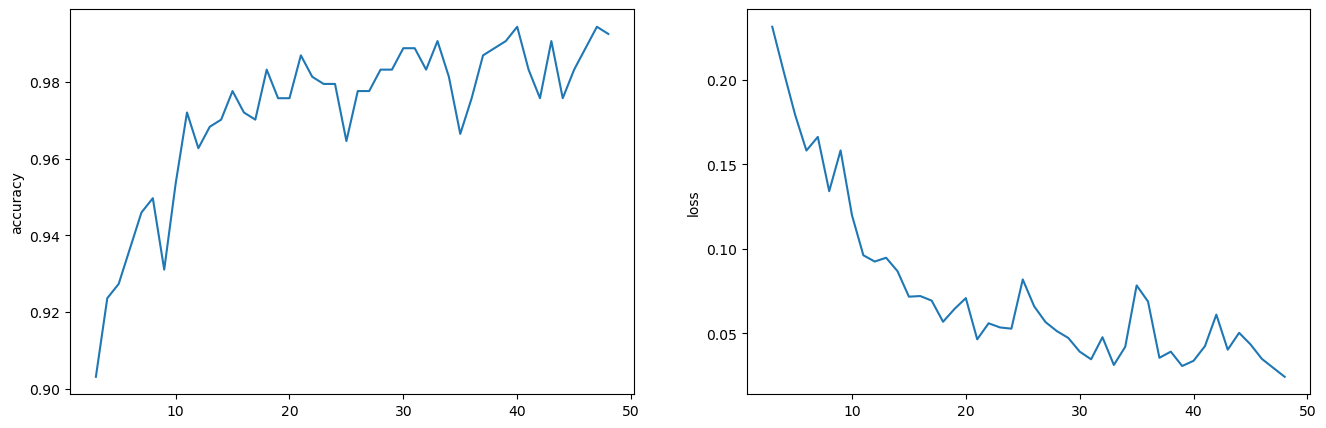

In [52]:
# Convertimos el historico a dataframe (formato de pandas)
df = pd.DataFrame(history.history)

# creamos un espacio para pintar nuestros graficos
f = plt.figure(figsize=(16, 5))

rows = 1
cols = 2

# Gráfico a la izquierda, vemos el accuracy de nuestro conjunto de entrada vs conjunto de validación.
ax = f.add_subplot(rows, cols, 1)
sns.lineplot(data=df["accuracy"].iloc[3:-1])


# Gráfico a la derecha, vemos el loss de nuestro conjunto de entrada vs conjunto de validación.
ax = f.add_subplot(rows, cols, 2)
sns.lineplot(data=df["loss"].iloc[3:-1]);

In [53]:
model.evaluate(X_test,y_test)

9/9 [==============================] - 0s 5ms/step - loss: 0.1385 - accuracy: 0.9736


[0.1385250836610794, 0.9735848903656006]